# Business Case 2

## Import Libraries

In [1]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
import xgboost
from xgboost import XGBClassifier
import lightgbm
from lightgbm import LGBMClassifier

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Data Preprocessing

In [4]:
excel_file_path = 'Needs.xls'

In [5]:
path_mb='/content/drive/My Drive/Fintech/Business Case 2/Needs.xls'

In [6]:
customers = pd.read_excel(path_mb, sheet_name='Needs')
products = pd.read_excel(path_mb, sheet_name='Products')

# Define the number of customers, products, and features
num_customers = customers.shape[0]
num_products = products.shape[0]
num_customer_features = customers.shape[1]
num_product_features = products.shape[1]

In [7]:
customer_features = customers.drop('ID', axis=1)
product_features = products.drop('IDProduct', axis=1)

no client with 0 income

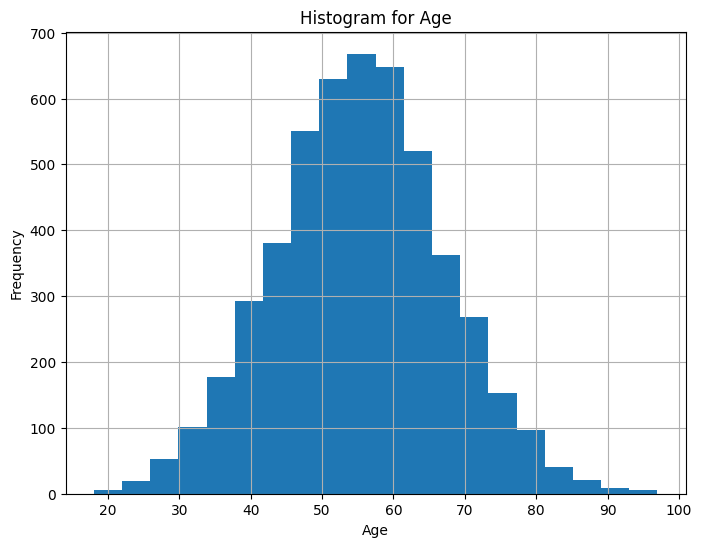

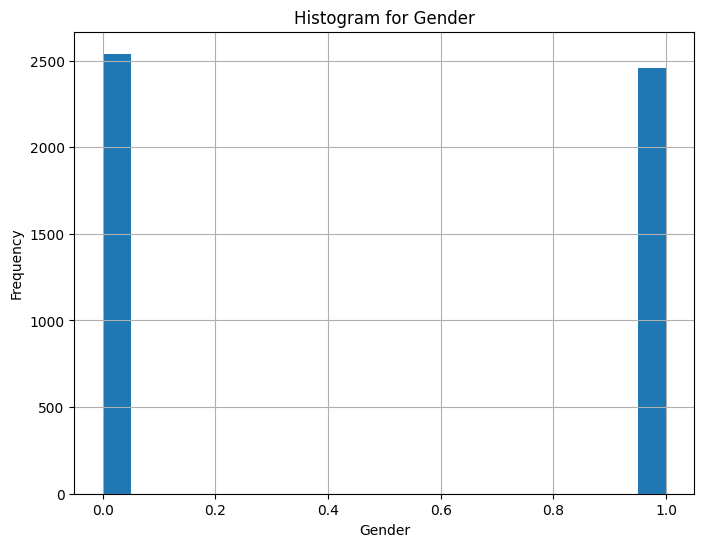

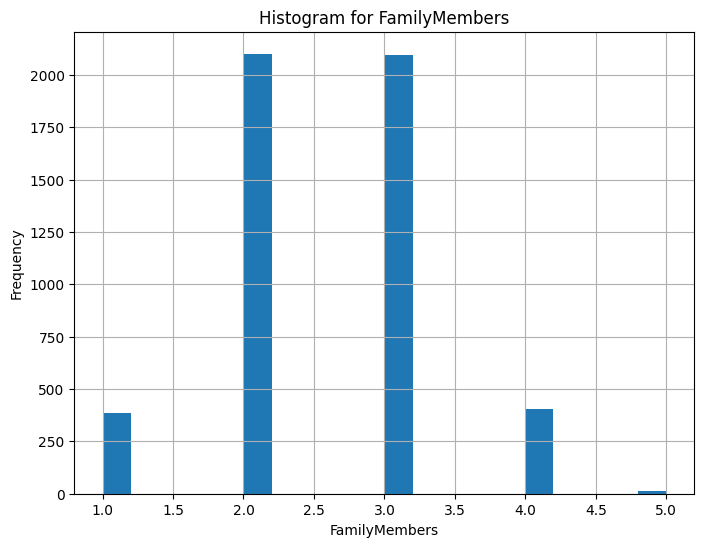

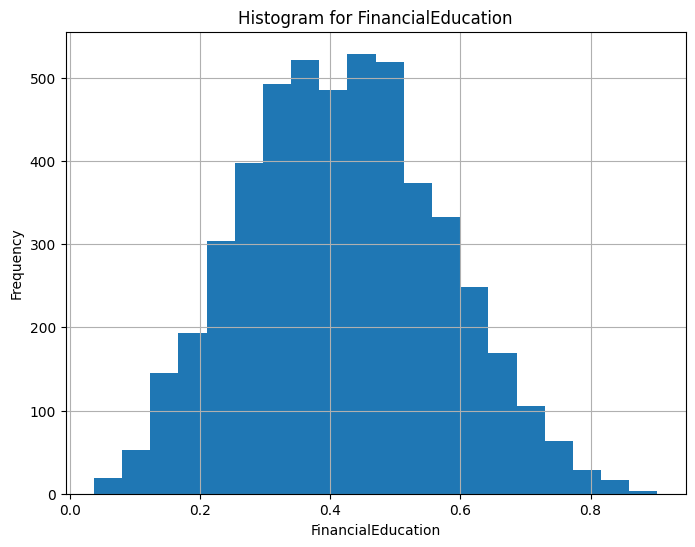

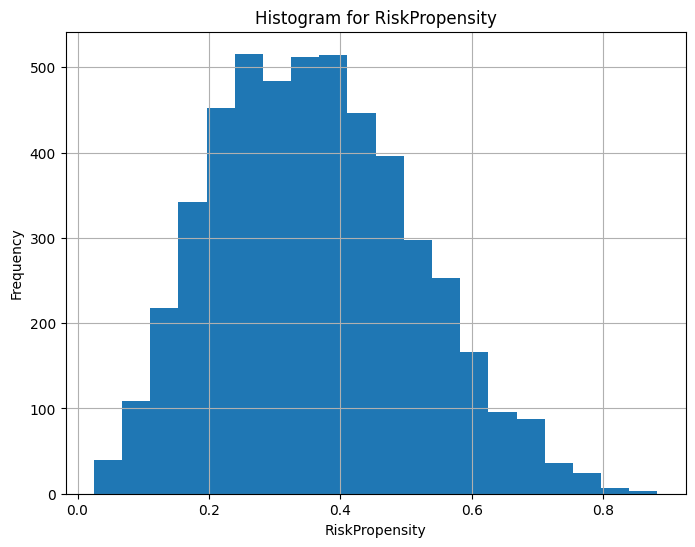

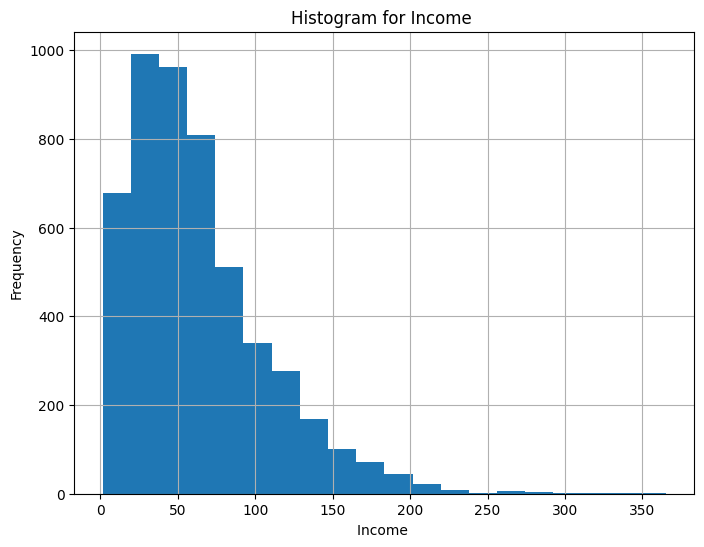

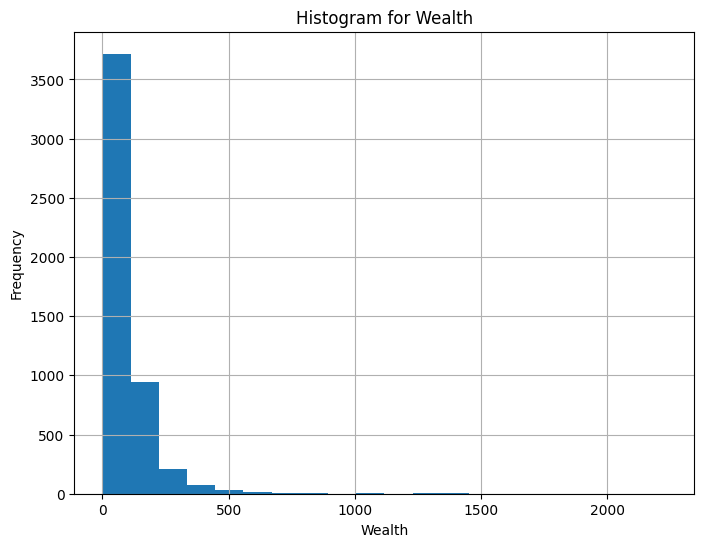

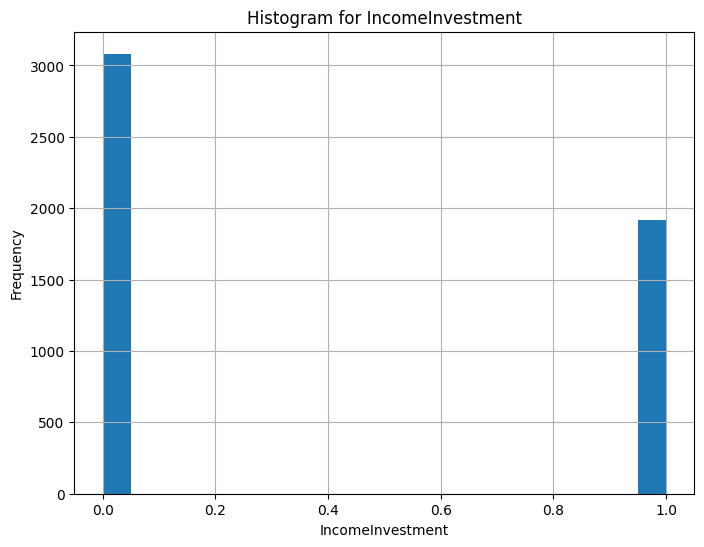

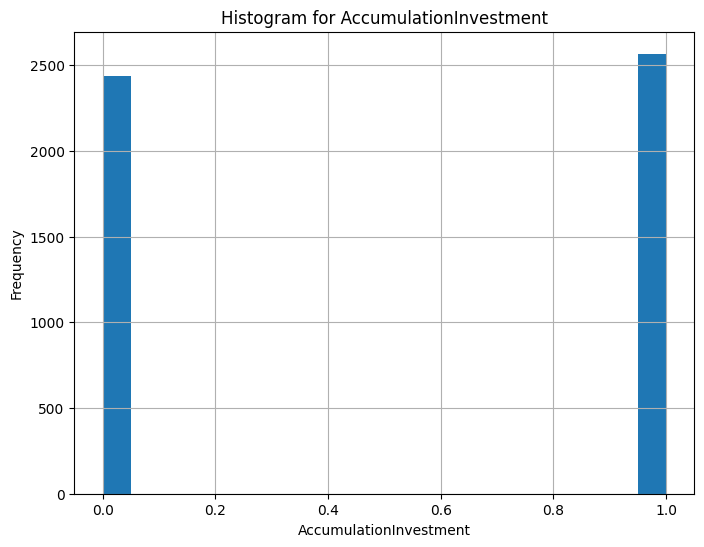

In [8]:
for column in customers.columns[1:]:
    # Create a histogram for each column
    plt.figure(figsize=(8, 6))
    customers[column].hist(bins=20)  # Adjust the number of bins as needed
    plt.title(f'Histogram for {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.show()

Now we decide to one hot encode Gender and scale Income and Wealth between 0 and 1 (probably it's better to use power transform first and then scale).

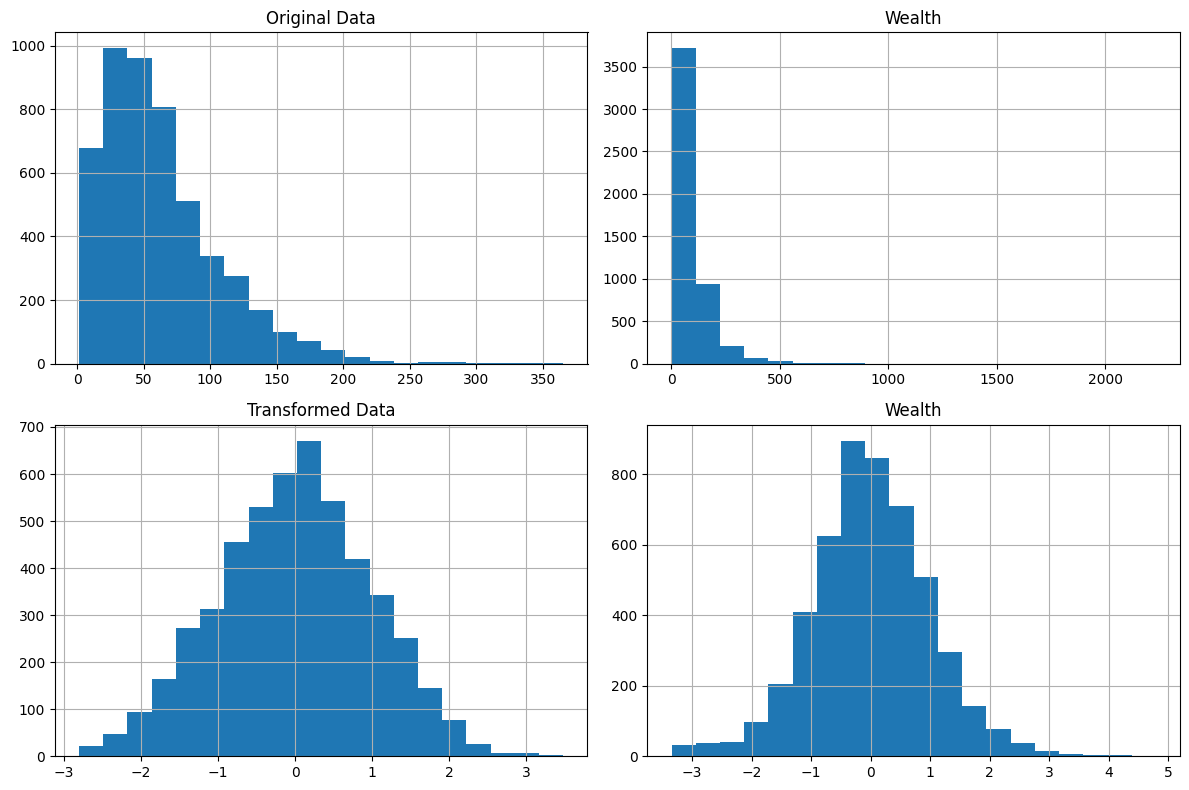

In [9]:
columns_to_transform = ['Income ', 'Wealth']

data_to_transform = customers[columns_to_transform]
power_transformer = PowerTransformer(method='yeo-johnson')  # 'yeo-johnson' works with both positive and negative values
transformed_data = power_transformer.fit_transform(data_to_transform)

df_transformed = pd.DataFrame(transformed_data, columns=columns_to_transform)

# Plot histograms before and after transformation for comparison
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
customers[columns_to_transform].hist(ax=axes[0], bins=20)
axes[0, 0].set_title('Original Data')
df_transformed.hist(ax=axes[1], bins=20)
axes[1, 0].set_title('Transformed Data')
plt.tight_layout()
plt.show()

In [10]:
categorical_variables = ['Gender']
not_normalized_variables = ['Income ', 'Wealth']

df_encoded = pd.get_dummies(customers, columns=categorical_variables)

df_encoded[not_normalized_variables] = df_transformed
df_encoded.head()

,ID,Age,FamilyMembers,FinancialEducation,RiskPropensity,Income,Wealth,IncomeInvestment,AccumulationInvestment,Gender_0,Gender_1
0,1,60,2,0.228685,0.233355,0.361265,-0.251035,0,1,1,0
1,2,78,2,0.358916,0.170911,-1.040664,0.827162,1,0,1,0
2,3,33,2,0.317515,0.249703,-0.973926,-0.008461,0,1,0,1
3,4,69,4,0.767685,0.654597,1.833249,2.239578,1,1,0,1
4,5,58,3,0.429719,0.349039,-1.070273,-0.140131,0,0,1,0


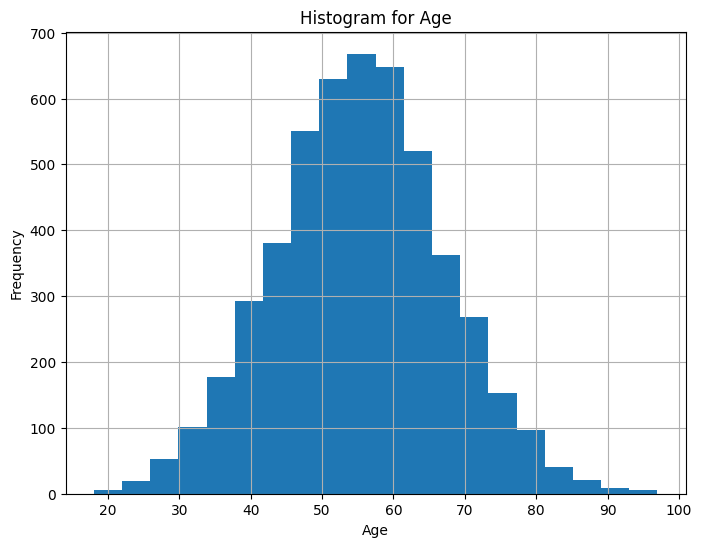

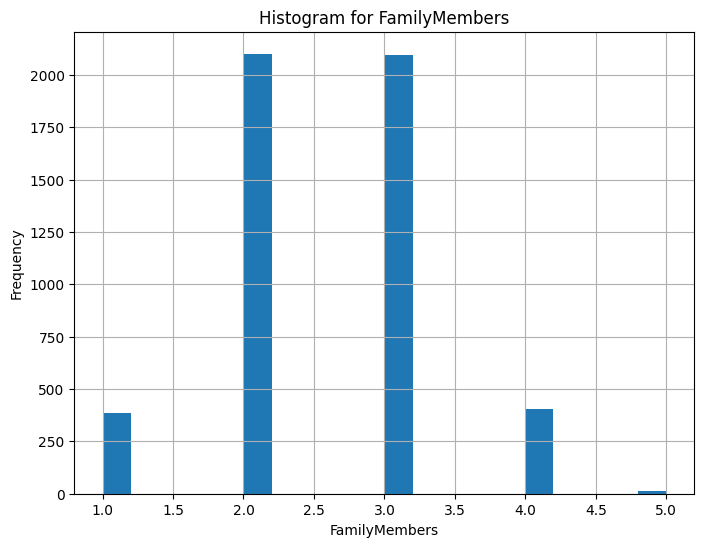

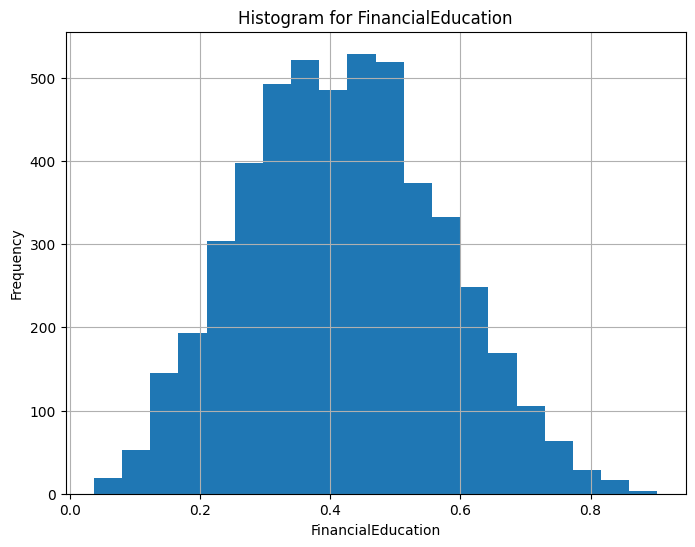

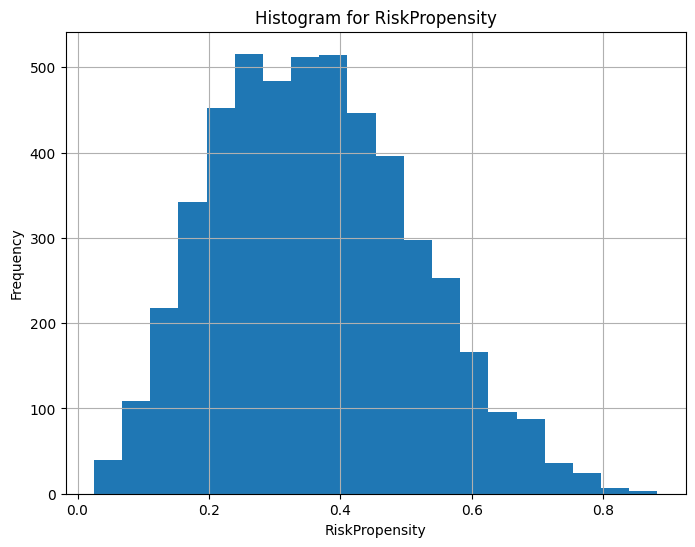

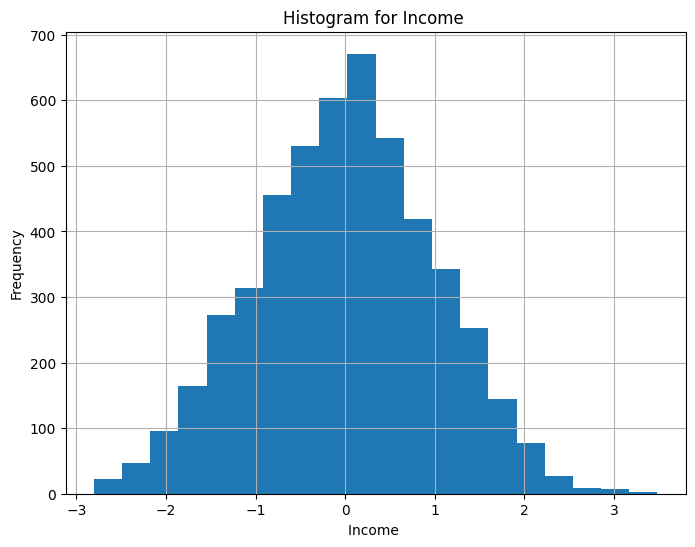

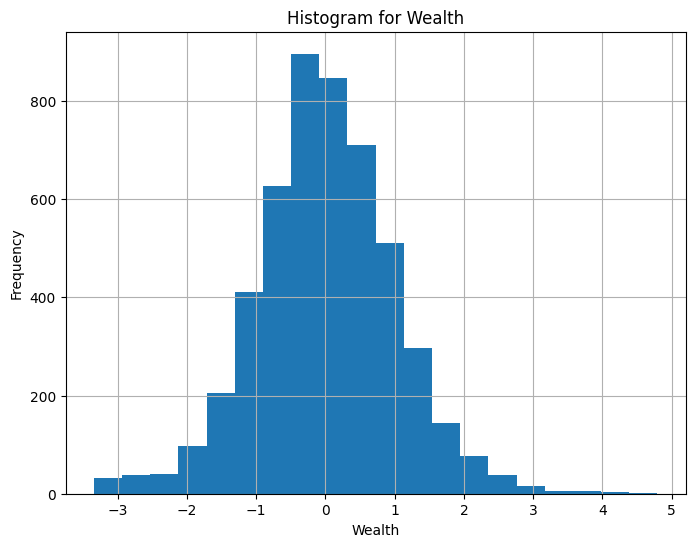

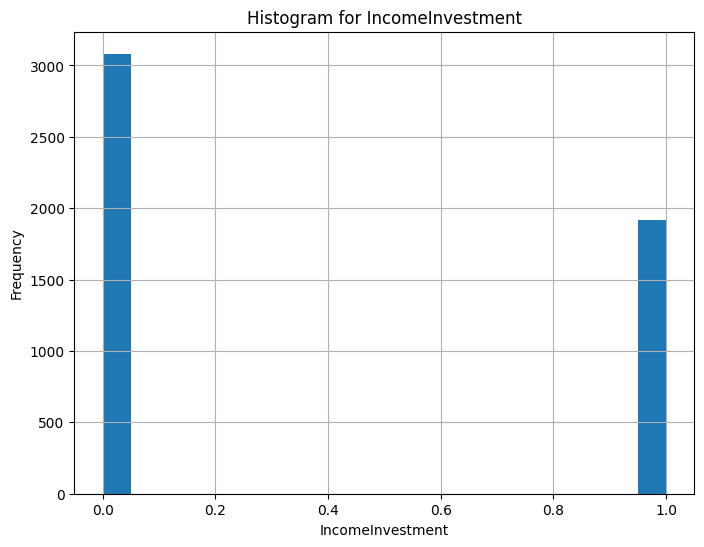

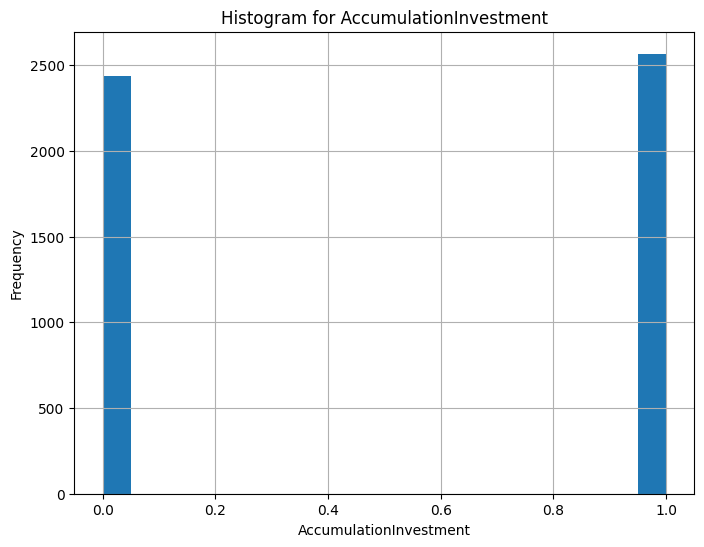

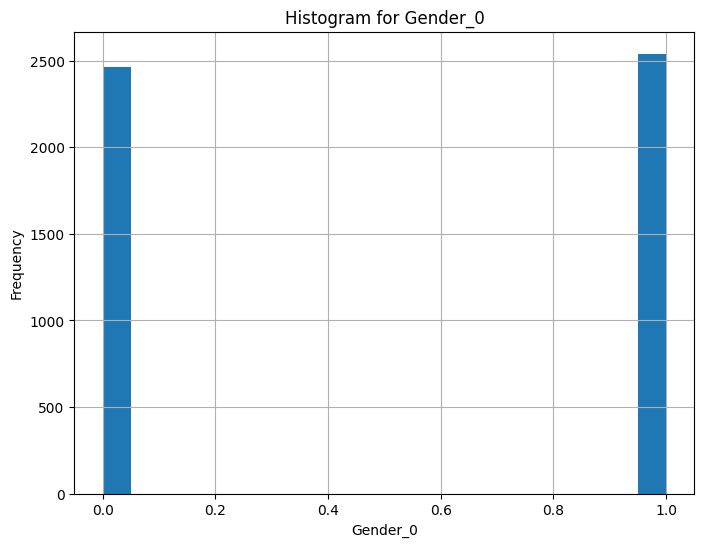

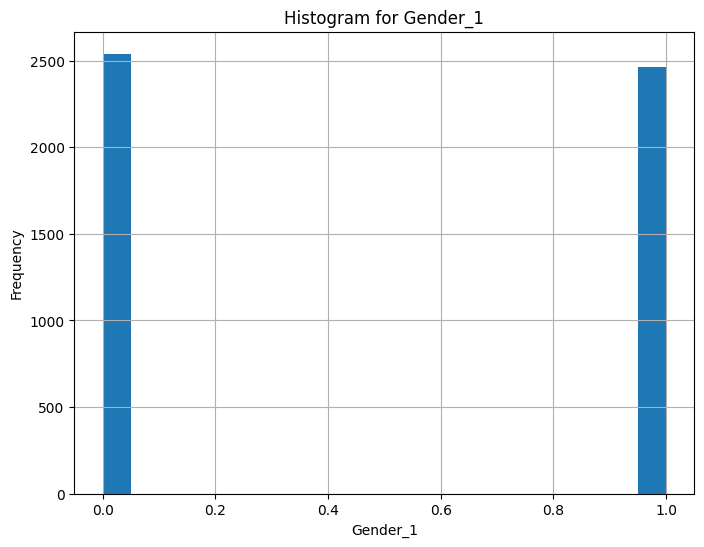

In [11]:
for column in df_encoded.columns[1:]:
    # Create a histogram for each column
    plt.figure(figsize=(8, 6))
    df_encoded[column].hist(bins=20)  # Adjust the number of bins as needed
    plt.title(f'Histogram for {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.show()

In [12]:
'''
selected_columns = df_encoded.columns[1:9]  # Assuming you want to select columns 1 to 5
df_selected = df_encoded[selected_columns]

sns.pairplot(df_selected, hue='IncomeInvestment', markers='o', palette='viridis')
plt.show()
'''

"\nselected_columns = df_encoded.columns[1:9]  # Assuming you want to select columns 1 to 5\ndf_selected = df_encoded[selected_columns]\n\nsns.pairplot(df_selected, hue='IncomeInvestment', markers='o', palette='viridis')\nplt.show()\n"

In [13]:
'''
selected_columns = df_encoded.columns[1:9]  # Assuming you want to select columns 1 to 5
df_selected = df_encoded[selected_columns]

sns.pairplot(df_selected, hue='AccumulationInvestment', markers='o', palette='viridis')
plt.show()
'''

"\nselected_columns = df_encoded.columns[1:9]  # Assuming you want to select columns 1 to 5\ndf_selected = df_encoded[selected_columns]\n\nsns.pairplot(df_selected, hue='AccumulationInvestment', markers='o', palette='viridis')\nplt.show()\n"

## truncated SVD

In [ ]:
# building the user_product matrix

user_product_matrix = np.zeros([num_customers, num_products])

for i in range(num_customers):
  for j in range(num_products):
    user_product_matrix[i][j] = 1 if ((customers['IncomeInvestment'][i] == 1 and products['Type'][j] == 0) or (customers['AccumulationInvestment'][i] == 1 and products['Type'][j] == 1)) else 0

print(user_product_matrix)

[[1. 0. 0. ... 1. 0. 1.]
 [0. 1. 1. ... 0. 1. 0.]
 [1. 0. 0. ... 1. 0. 1.]
 ...
 [1. 0. 0. ... 1. 0. 1.]
 [0. 0. 0. ... 0. 0. 0.]
 [1. 1. 1. ... 1. 1. 1.]]


In [ ]:
# Split the data into train and validation sets
# Split the data into training and combined validation-test sets
train_data, val_test_data = train_test_split(user_product_matrix, test_size=0.2, random_state=42)

# Split the combined validation-test set into validation and test sets
val_data, test_data = train_test_split(val_test_data, test_size=0.5, random_state=42)

# Output the shapes of the resulting sets
print("Train data shape:", train_data.shape)
print("Validation data shape:", val_data.shape)
print("Test data shape:", test_data.shape)
# Train the SVD model
n_components = 5
svd = TruncatedSVD(n_components=n_components, random_state=42)
svd.fit(train_data)

# Transform and reconstruct the user-item matrix
train_data_reconstructed = svd.inverse_transform(svd.transform(train_data))

# Calculate RMSE on the validation set
val_data_reconstructed = svd.inverse_transform(svd.transform(val_data))
rmse = np.sqrt(mean_squared_error(val_data, val_data_reconstructed))
print("Validation RMSE:", rmse)


Train data shape: (4000, 11)
Validation data shape: (500, 11)
Test data shape: (500, 11)
Validation RMSE: 1.738056625879834e-16


In [ ]:
test_data_reconstructed = svd.inverse_transform(svd.transform(test_data))

rmse = np.sqrt(mean_squared_error(test_data, test_data_reconstructed))
print("Test RMSE:", rmse)

Test RMSE: 1.6775215450826976e-16


## Clustering + Classification + Recommendation

In [14]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import DBSCAN

In [15]:
# Install additional packages
!pip install umap
import umap
!pip install umap-learn
import umap.umap_ as umap
!pip install hdbscan
import hdbscan

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 12.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached Cython-0.29.37-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_24_x86_64.whl (1.9 MB)
  Created wheel for hdbscan: filename=hdbscan-0.8.33-cp310-cp310-linux_x86_64.whl size=3039283 sha256=9fcacbc05f7b3ff062b25e599a9f2170a85d0401b644e5cb7456a5fff5d8ff61
  Stored in directory: /root/.cache/pip/wheels/75/0b/3b/dc4f60b7cc455efaefb62883a7483e76f09d06ca81cf87d610
Successfully built hdbscan
  Attempting uninstall: cython
    Found existing installation: Cython 3.0.9
    Uninstalling Cython-3.0.9:
      Successfully uninstalled Cython-3.0.9


### Attempt of dimensionality reduction

In [16]:
df_encoded = df_encoded.drop('ID', axis=1)

In [17]:
# 1. perform clustering on client features without acc/inc investment
# 1.1. UMAP decomposition
UMAP_Object = umap.UMAP(n_neighbors=5, min_dist=0.3, n_components=3)
ComponentValues = UMAP_Object.fit_transform(df_encoded)
ReducedData = pd.DataFrame(data=ComponentValues, columns=['Col1', 'Col2', 'Col3'])
dataset_reduced_umap = ReducedData

In [18]:
print(ReducedData.head())

        Col1       Col2      Col3
0  10.654042   1.214590 -2.639569
1  12.810160  12.124070  9.806890
2   3.641702  11.021420  0.521065
3  13.992319   9.280523  7.129380
4  11.617222  -3.639544  1.352509


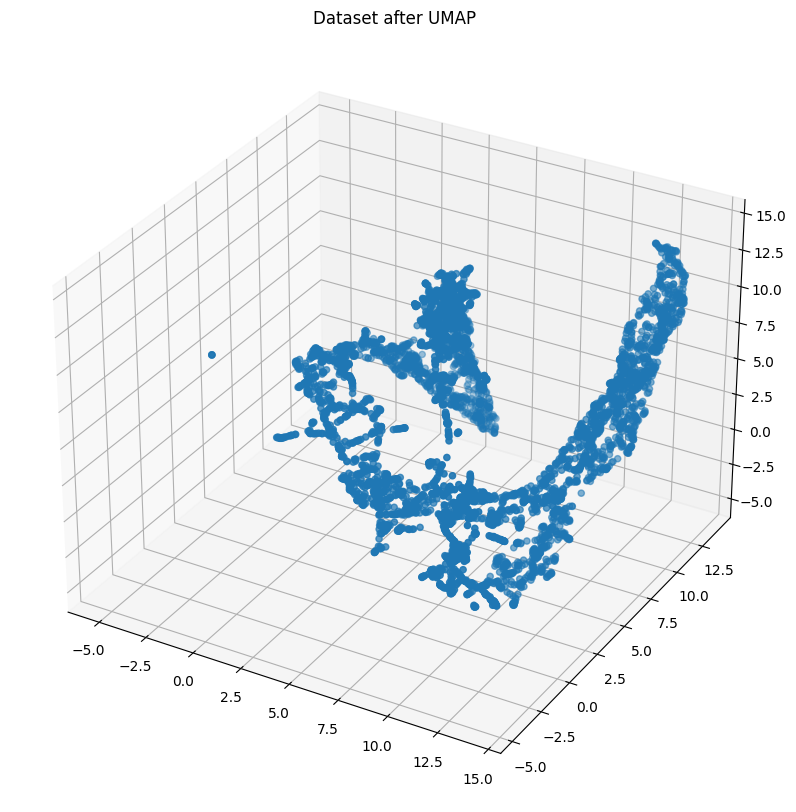

In [19]:
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection='3d')
ax.scatter3D(ReducedData['Col1'], ReducedData['Col2'], ReducedData['Col3'])
ax.set_title('Dataset after UMAP')
plt.show()

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=3, random_state=42)
ComponentValues = tsne.fit_transform(df_encoded)

ReducedData = pd.DataFrame(data=ComponentValues, columns=['Col1', 'Col2', 'Col3'])

dataset_reduced_tsne = ReducedData

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(ReducedData['Col1'],
           ReducedData['Col2'],
           ReducedData['Col3'],
          cmap='viridis')
ax.set_title('Dataset after TSNE')
plt.show()

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3, random_state=42)
ComponentValues = pca.fit_transform(df_encoded)

ReducedData = pd.DataFrame(data=ComponentValues, columns=['Col1', 'Col2', 'Col3'])

dataset_reduced_pca = ReducedData

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(ReducedData['Col1'],
           ReducedData['Col2'],
           ReducedData['Col3'],
           cmap='viridis')
ax.set_title('Dataset after PCA')
plt.show()

### Attempt of Clustering

#### DBSCAN

In [ ]:
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

optimal_parameters = []

data = df_encoded

# Define a range of values for eps and min_samples
eps_values = np.arange(0.5, 2.0, 0.1)
min_samples_values = np.arange(5, 20, 1)
# Initialize variables to store the optimal parameters and silhouette score
best_eps = None
best_min_samples = None
best_silhouette_score = -1  # Set to a low initial value

# Iterate over different combinations of eps and min_samples
for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        clusters = dbscan.fit_predict(data)
        try:
          silhouette_avg = silhouette_score(data, clusters)
        except ValueError:
          silhouette_avg = -1
          pass
            #print(f"eps = {eps}")
            #print(f"min_samples = {min_samples}")
            #print(f"silhouette score = {silhouette_avg}")

            # Update optimal parameters if the silhouette score is higher
        if silhouette_avg > best_silhouette_score:
            best_silhouette_score = silhouette_avg
            best_eps = eps
            best_min_samples = min_samples

    # Print the optimal parameters and silhouette score for the current dataset
print(f'Optimal Parameters for Dataset {i+1}: eps={best_eps}, min_samples={best_min_samples}')
optimal_parameters.append((best_eps, best_min_samples))
print(f'Optimal Silhouette Score for Dataset {i+1}: {best_silhouette_score}\n')

    # Now, you can use these optimal parameters to perform DBSCAN clustering and visualization
dbscan = DBSCAN(eps=best_eps, min_samples=best_min_samples)
clusters = dbscan.fit_predict(data)
num_clusters = len(set(clusters)) - (1 if -1 in clusters else 0) # excluding noise points with label -1

print(num_clusters)

In [ ]:
# 1.2. Clustering
eps = best_eps
min_samples = best_min_samples
dbscan = DBSCAN(eps=eps, min_samples=min_samples)

clusters = dbscan.fit_predict(df_encoded)
num_clusters = len(set(clusters)) - (1 if -1 in clusters else 0) # excluding noise points with label -1

print(f'Number of identified clusters: {num_clusters}')

#### HDBSCAN

In [ ]:
import numpy as np
import hdbscan
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

optimal_parameters = []

data = df_encoded

# Define a range of values for min_cluster_size and min_samples
min_cluster_size_values = np.arange(5, 20, 1)
min_samples_values = np.arange(1, 10, 1)
# Initialize variables to store the optimal parameters and silhouette score
best_min_cluster_size = None
best_min_samples = None
best_silhouette_score = -1  # Set to a low initial value

# Iterate over different combinations of min_cluster_size and min_samples
for min_cluster_size in min_cluster_size_values:
    for min_samples in min_samples_values:
        clusterer = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, min_samples=min_samples)
        clusters = clusterer.fit_predict(data)
        try:
            silhouette_avg = silhouette_score(data, clusters)
        except ValueError:
            silhouette_avg = -1
            pass
        # Update optimal parameters if the silhouette score is higher
        if silhouette_avg > best_silhouette_score:
            best_silhouette_score = silhouette_avg
            best_min_cluster_size = min_cluster_size
            best_min_samples = min_samples

# Print the optimal parameters and silhouette score
print(f'Optimal Parameters: min_cluster_size={best_min_cluster_size}, min_samples={best_min_samples}')
print(f'Optimal Silhouette Score: {best_silhouette_score}\n')

# Now, you can use these optimal parameters to perform HDBSCAN clustering and visualization
clusterer = hdbscan.HDBSCAN(min_cluster_size=best_min_cluster_size, min_samples=best_min_samples)
clusters = clusterer.fit_predict(data)
num_clusters = len(set(clusters)) - (1 if -1 in clusters else 0)  # excluding noise points with label -1

print(num_clusters)

In [ ]:
df_encoded['Cluster'] = clusters
df_encoded.info()

# Create separate histograms for each column
for col in df_encoded.columns[:-1]:  # Exclude the 'Cluster' column
    plt.figure(figsize=(6, 4))
    for cluster, group_data in df_encoded.groupby('Cluster'):
        plt.hist(group_data[col], bins=20, alpha=0.6, label=f'Cluster {cluster}')

    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.title(f'Histogram for {col}')
    plt.legend()
    plt.show()

#### KMeans

In [21]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [ ]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

optimal_parameters = []

data = df_encoded

# Define a range of values for n_clusters
n_clusters_values = np.arange(2, 11)  # Adjust the range as needed

# Initialize variables to store the optimal parameters and silhouette score
best_n_clusters = None
best_silhouette_score = -1  # Set to a low initial value

# Iterate over different values of n_clusters
for n_clusters in n_clusters_values:
    kmeans = KMeans(n_clusters=n_clusters, n_init=10, random_state=42)  # Set n_init explicitly
    clusters = kmeans.fit_predict(data)
    try:
        silhouette_avg = silhouette_score(data, clusters)
    except ValueError:
        silhouette_avg = -1
        pass
    # Update optimal parameters if the silhouette score is higher
    if silhouette_avg > best_silhouette_score:
        best_silhouette_score = silhouette_avg
        best_n_clusters = n_clusters

# Print the optimal parameters and silhouette score
print(f'Optimal Parameters: n_clusters={best_n_clusters}')
print(f'Optimal Silhouette Score: {best_silhouette_score}\n')

In [20]:
# Now, you can use these optimal parameters to perform KMeans clustering and visualization
kmeans = KMeans(n_clusters=best_n_clusters, n_init=10, random_state=42)  # Set n_init explicitly
clusters = kmeans.fit_predict(data)
num_clusters = len(set(clusters))

print(num_clusters)

NameError: name 'KMeans' is not defined

In [ ]:
df_encoded['Cluster'] = clusters
df_encoded.info()

In [ ]:
# Create separate histograms for each column
for col in df_encoded.columns[:-1]:  # Exclude the 'Cluster' column
    plt.figure(figsize=(6, 4))
    for cluster, group_data in df_encoded.groupby('Cluster'):
        plt.hist(group_data[col], bins=20, alpha=0.6, label=f'Cluster {cluster}')

    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.title(f'Histogram for {col}')
    plt.legend()
    plt.show()

#### clustering on decomposed datasets - DBSCAN

on the not decomposed dataset the only relevant algorithm is kNN, which only clusters by age. Let's try on the decomposed datasets.

In [ ]:

datasets = [dataset_reduced_umap, dataset_reduced_pca, dataset_reduced_tsne]
reductions = ["Umap", "PCA", "tSNE"]

In [ ]:
optimal_parameters = []

for i, data in enumerate(datasets):
    print(f"\nOptimizing parameters for Dataset {i+1}:")

    # Define a range of values for eps and min_samples
    eps_values = np.arange(0.5, 2.0, 0.1)
    min_samples_values = np.arange(5, 20, 1)

    # Initialize variables to store the optimal parameters and silhouette score
    best_eps = None
    best_min_samples = None
    best_silhouette_score = -1  # Set to a low initial value

    # Iterate over different combinations of eps and min_samples
    for eps in eps_values:
        for min_samples in min_samples_values:
            dbscan = DBSCAN(eps=eps, min_samples=min_samples)
            clusters = dbscan.fit_predict(data)
            try:
              silhouette_avg = silhouette_score(data, clusters)
            except ValueError:
              silhouette_avg = -1
              pass
            #print(f"eps = {eps}")
            #print(f"min_samples = {min_samples}")
            #print(f"silhouette score = {silhouette_avg}")

            # Update optimal parameters if the silhouette score is higher
            if silhouette_avg > best_silhouette_score:
                best_silhouette_score = silhouette_avg
                best_eps = eps
                best_min_samples = min_samples

    # Print the optimal parameters and silhouette score for the current dataset
    print(f'Optimal Parameters for Dataset {i+1}: eps={best_eps}, min_samples={best_min_samples}')
    optimal_parameters.append((best_eps, best_min_samples))
    print(f'Optimal Silhouette Score for Dataset {i+1}: {best_silhouette_score}\n')

    # Now, you can use these optimal parameters to perform DBSCAN clustering and visualization
    dbscan = DBSCAN(eps=best_eps, min_samples=best_min_samples)
    clusters = dbscan.fit_predict(data)
    num_clusters = len(set(clusters)) - (1 if -1 in clusters else 0) # excluding noise points with label -1
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(datasets[i]['Col1'], datasets[i]['Col2'], datasets[i]['Col3'], c=clusters, cmap='viridis')
    ax.set_title(f'DBSCAN Clusters - {reductions[i]} - {num_clusters} clusters')
    plt.show()

#### decomposed - HDBSCAN

In [ ]:
import numpy as np
from hdbscan import HDBSCAN
from sklearn.metrics import silhouette_score

optimal_parameters_hdbscan = []

for i, data in enumerate(datasets):
    print(f"\nOptimizing parameters for Dataset {i+1}:")

    # Define a range of values for min_cluster_size and min_samples
    min_cluster_size_values = np.arange(5, 20, 1)
    min_samples_values = np.arange(1, 10, 1)

    # Initialize variables to store the optimal parameters and silhouette score
    best_min_cluster_size = None
    best_min_samples = None
    best_silhouette_score = -1  # Set to a low initial value

    # Iterate over different combinations of min_cluster_size and min_samples
    for min_cluster_size in min_cluster_size_values:
        for min_samples in min_samples_values:
            clusterer = HDBSCAN(min_cluster_size=min_cluster_size, min_samples=min_samples)
            clusters = clusterer.fit_predict(data)
            try:
                silhouette_avg = silhouette_score(data, clusters)
            except ValueError:
                silhouette_avg = -1
                pass

            # Update optimal parameters if the silhouette score is higher
            if silhouette_avg > best_silhouette_score:
                best_silhouette_score = silhouette_avg
                best_min_cluster_size = min_cluster_size
                best_min_samples = min_samples

    # Print the optimal parameters and silhouette score for the current dataset
    print(f'Optimal Parameters for Dataset {i+1}: min_cluster_size={best_min_cluster_size}, min_samples={best_min_samples}')
    optimal_parameters_hdbscan.append((best_min_cluster_size, best_min_samples))
    print(f'Optimal Silhouette Score for Dataset {i+1}: {best_silhouette_score}\n')

    # Now, you can use these optimal parameters to perform HDBSCAN clustering and visualization
    hdbscan = HDBSCAN(min_cluster_size=best_min_cluster_size, min_samples=best_min_samples)
    clusters = hdbscan.fit_predict(data)

    # Now, you can use these optimal parameters to perform DBSCAN clustering and visualization
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(datasets[i]['Col1'], datasets[i]['Col2'], datasets[i]['Col3'], c=clusters, cmap='viridis')
    ax.set_title(f'HDBSCAN Clusters - {reductions[i]} - {num_clusters} clusters')
    plt.show()

#### decomposed - KMeans

In [ ]:
optimal_parameters = []

for i, data in enumerate(datasets):
    print(f"\nOptimizing parameters for Dataset {i+1}:")

    # Define a range of values for n_clusters
    n_clusters_values = np.arange(2, 11)  # Adjust the range as needed

    # Initialize variables to store the optimal parameters and silhouette score
    best_n_clusters = None
    best_silhouette_score = -1  # Set to a low initial value

    # Iterate over different values of n_clusters
    for n_clusters in n_clusters_values:
        kmeans = KMeans(n_clusters=n_clusters, n_init=10, random_state=42)  # Set n_init explicitly
        clusters = kmeans.fit_predict(data)
        try:
            silhouette_avg = silhouette_score(data, clusters)
        except ValueError:
            silhouette_avg = -1
            pass

        # Update optimal parameters if the silhouette score is higher
        if silhouette_avg > best_silhouette_score:
            best_silhouette_score = silhouette_avg
            best_n_clusters = n_clusters

    # Print the optimal parameters and silhouette score for the current dataset
    print(f'Optimal Parameters for Dataset {i+1}: n_clusters={best_n_clusters}')
    optimal_parameters.append(best_n_clusters)
    print(f'Optimal Silhouette Score for Dataset {i+1}: {best_silhouette_score}\n')

    # Now, you can use these optimal parameters to perform KMeans clustering and visualization
    kmeans = KMeans(n_clusters=best_n_clusters, n_init=10, random_state=42)  # Set n_init explicitly
    clusters = kmeans.fit_predict(data)
    num_clusters = len(set(clusters))

    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(data['Col1'], data['Col2'], data['Col3'], c=clusters, cmap='viridis')
    ax.set_title(f'KMeans Clusters - Dataset {i+1} - {num_clusters} clusters')
    plt.show()


Best result: UMAP + kNN with n_clusters=4. Gave 4 clusters, let's dig deeper.

In [22]:
# Now, you can use these optimal parameters to perform KMeans clustering and visualization
kmeans = KMeans(n_clusters=4, n_init=10, random_state=42)  # Set n_init explicitly
clusters = kmeans.fit_predict(dataset_reduced_umap)
num_clusters = len(set(clusters))

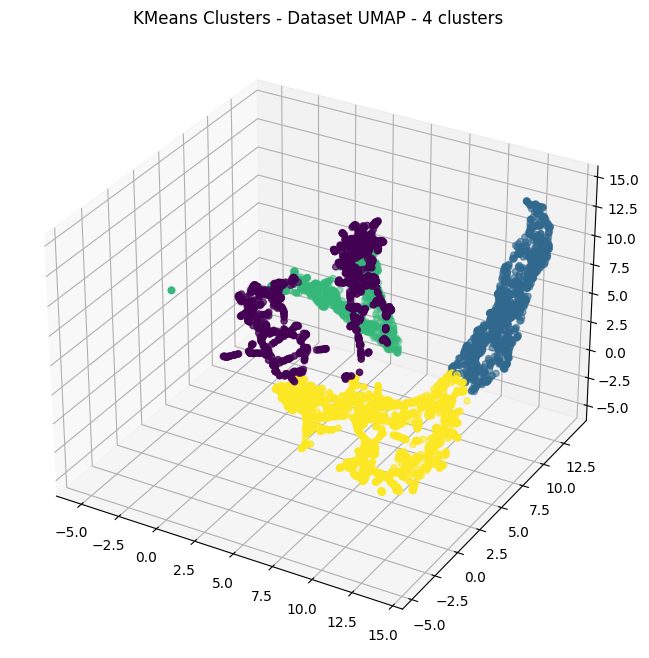

In [25]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(dataset_reduced_umap['Col1'], dataset_reduced_umap['Col2'], dataset_reduced_umap['Col3'], c=clusters, cmap='viridis')
ax.set_title(f'KMeans Clusters - Dataset UMAP - {num_clusters} clusters')
plt.show()

In [27]:
print(num_clusters)

4


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Age                     5000 non-null   int64  
 1   FamilyMembers           5000 non-null   int64  
 2   FinancialEducation      5000 non-null   float64
 3   RiskPropensity          5000 non-null   float64
 4   Income                  5000 non-null   float64
 5   Wealth                  5000 non-null   float64
 6   IncomeInvestment        5000 non-null   int64  
 7   AccumulationInvestment  5000 non-null   int64  
 8   Gender_0                5000 non-null   uint8  
 9   Gender_1                5000 non-null   uint8  
 10  Cluster                 5000 non-null   int32  
dtypes: float64(4), int32(1), int64(4), uint8(2)
memory usage: 341.9 KB


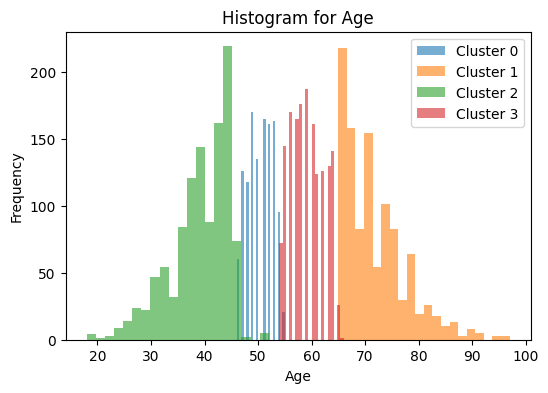

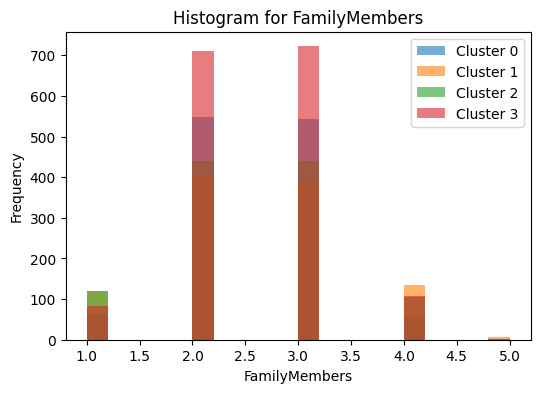

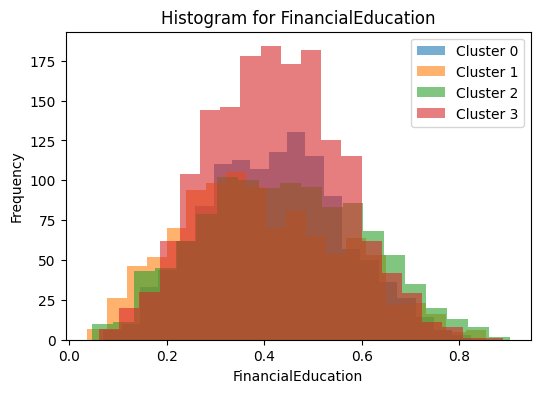

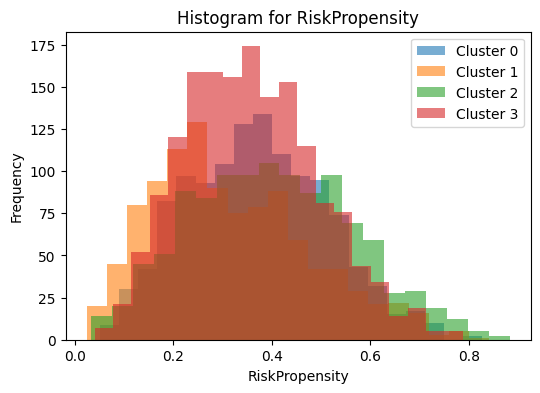

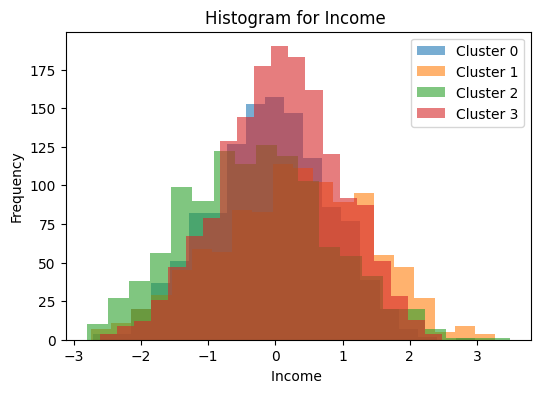

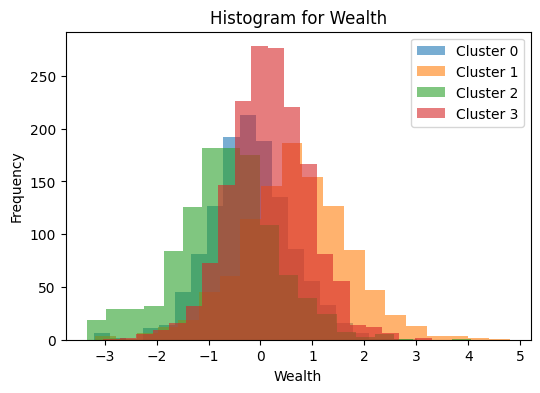

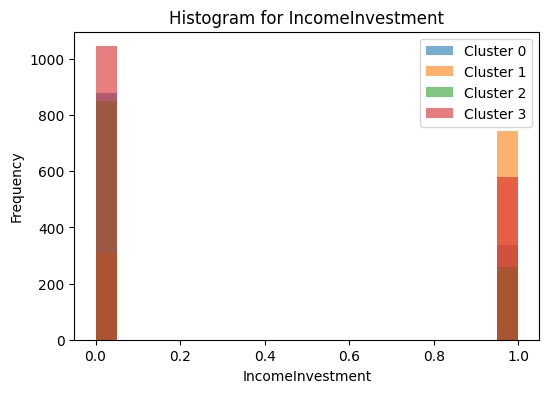

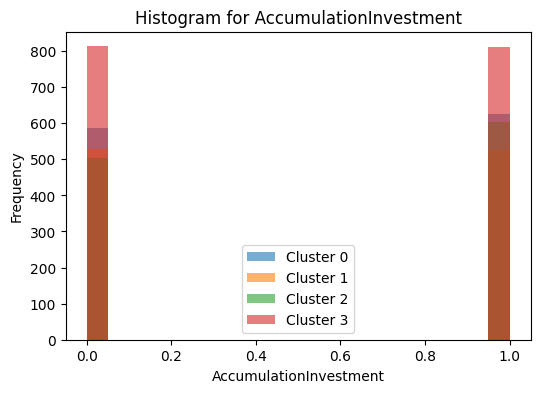

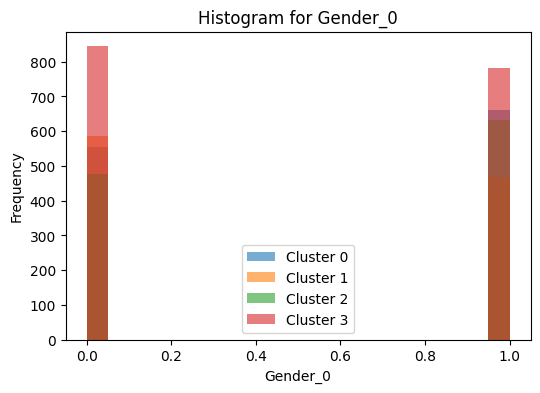

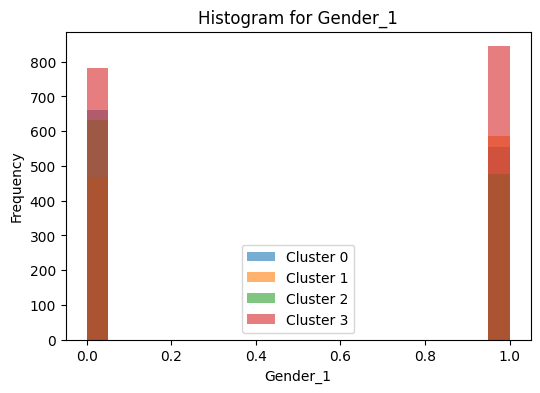

In [26]:
df_encoded['Cluster'] = clusters
df_encoded.info()

# Create separate histograms for each column
for col in df_encoded.columns[:-1]:  # Exclude the 'Cluster' column
    plt.figure(figsize=(6, 4))
    for cluster, group_data in df_encoded.groupby('Cluster'):
        plt.hist(group_data[col], bins=20, alpha=0.6, label=f'Cluster {cluster}')

    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.title(f'Histogram for {col}')
    plt.legend()
    plt.show()

It is still clustering by age. I think we can keep this column vector and integrate it with the rest of the information that we have.

### Classification

In [25]:
# 2. New classes and classification
#### We will use as classes the ones of inc inv and acc inv AND the cluster column

df_encoded['CombinedClasses'] = df_encoded['IncomeInvestment'] + 2 * df_encoded['AccumulationInvestment']

# Display the new column
print(df_encoded['CombinedClasses'].value_counts())

2    1568
0    1514
3     998
1     920
Name: CombinedClasses, dtype: int64


In [26]:
df_encoded.describe()

,Age,FamilyMembers,FinancialEducation,RiskPropensity,Income,Wealth,IncomeInvestment,AccumulationInvestment,Gender_0,Gender_1,Cluster,CombinedClasses
count,5000.000000,5000.000000,5000.000000,5000.000000,5.000000e+03,5.000000e+03,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,55.253400,2.510600,0.419123,0.362686,1.762146e-16,-3.716139e-16,0.383600,0.513200,0.508000,0.492000,1.453600,1.410000
std,11.971694,0.761842,0.151383,0.151124,1.000100e+00,1.000100e+00,0.486311,0.499876,0.499986,0.499986,1.093657,1.116669
min,18.000000,1.000000,0.036099,0.024790,-2.806228e+00,-3.343850e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.000000,2.000000,0.308067,0.246444,-6.730769e-01,-6.040166e-01,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,55.000000,3.000000,0.416735,0.354526,1.950210e-02,-1.241078e-02,0.000000,1.000000,1.000000,0.000000,1.000000,2.000000
75%,63.000000,3.000000,0.523393,0.467125,6.751645e-01,6.272554e-01,1.000000,1.000000,1.000000,1.000000,2.000000,2.000000
max,97.000000,5.000000,0.902933,0.882709,3.485485e+00,4.794582e+00,1.000000,1.000000,1.000000,1.000000,3.000000,3.000000


In [27]:
# Select columns for one-hot encoding
columns_to_encode = ['Cluster']

# Perform one-hot encoding on the 'Cluster' variable
cluster_encoded = pd.get_dummies(df_encoded[columns_to_encode], drop_first=True)

cluster_encoded.head()

,Cluster
0,1
1,2
2,3
3,2
4,1


In [28]:
from sklearn.preprocessing import OneHotEncoder

onehot_encoder = OneHotEncoder(sparse_output=False)
cluster_encoded = onehot_encoder.fit_transform(df_encoded[['Cluster']])
cluster_df = pd.DataFrame(cluster_encoded, columns=[f'Cluster_{i}' for i in range(cluster_encoded.shape[1])])
X_encoded = pd.concat([df_encoded, cluster_df], axis=1)

X_encoded.head()

,Age,FamilyMembers,FinancialEducation,RiskPropensity,Income,Wealth,IncomeInvestment,AccumulationInvestment,Gender_0,Gender_1,Cluster,CombinedClasses,Cluster_0,Cluster_1,Cluster_2,Cluster_3
0,60,2,0.228685,0.233355,0.361265,-0.251035,0,1,1,0,1,2,0.0,1.0,0.0,0.0
1,78,2,0.358916,0.170911,-1.040664,0.827162,1,0,1,0,2,1,0.0,0.0,1.0,0.0
2,33,2,0.317515,0.249703,-0.973926,-0.008461,0,1,0,1,3,2,0.0,0.0,0.0,1.0
3,69,4,0.767685,0.654597,1.833249,2.239578,1,1,0,1,2,3,0.0,0.0,1.0,0.0
4,58,3,0.429719,0.349039,-1.070273,-0.140131,0,0,1,0,1,0,0.0,1.0,0.0,0.0


In [29]:
X_cols = ['Age', 'FamilyMembers', 'FinancialEducation', 'RiskPropensity',
       'Income ', 'Wealth', 'Gender_0', 'Gender_1', 'Cluster_0', 'Cluster_1', 'Cluster_2', 'Cluster_3']
X = X_encoded[X_cols]  # Features
y = X_encoded[['CombinedClasses']]

# Split the data into training and testing sets for IncomeInvestment
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


encoder = OneHotEncoder(sparse_output=False)
y_train_encoded = encoder.fit_transform(y_train[['CombinedClasses']])
y_test_encoded = encoder.transform(y_test[['CombinedClasses']])

In [30]:
tf.random.set_seed(42)

model = Sequential([
    Dense(100, input_dim=X_train.shape[1], activation='relu'),
    Dense(50, activation='relu'),
    Dense(y_train_encoded.shape[1], activation='softmax')
])

model.summary()

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(X_train, y_train_encoded, epochs=200, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               1300      
                                                                 
 dense_1 (Dense)             (None, 50)                5050      
                                                                 
 dense_2 (Dense)             (None, 4)                 204       
                                                                 
Total params: 6554 (25.60 KB)
Trainable params: 6554 (25.60 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/200
100/100 [==============================] - 2s 5ms/step - loss: 1.4403 - accuracy: 0.3647 - val_loss: 1.2609 - val_accuracy: 0.4375
Epoch 2/200
100/100 [==============================] - 0s 3ms/step - loss: 1.2468 - accuracy: 0.4609 - val_loss: 1.2159 - val_accuracy: 0.4688


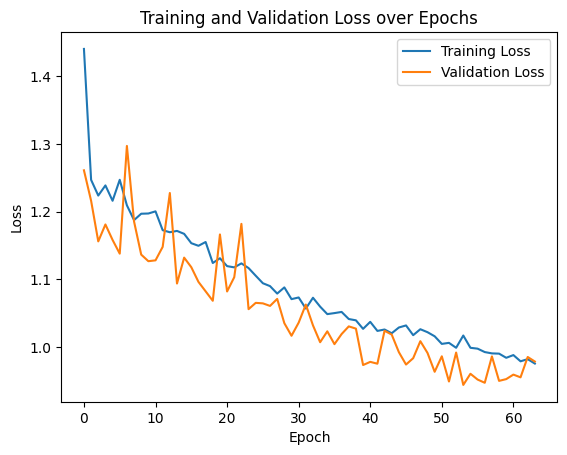

Best Epoch: 54


In [31]:
# Plot training and validation errors
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.show()

# Identify the best epoch
best_epoch = np.argmin(history.history['val_loss']) + 1
print(f'Best Epoch: {best_epoch}')

In [32]:
# Predict on the test set
y_pred_proba = model.predict(X_test)
y_pred = np.argmax(y_pred_proba, axis=1)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

32/32 [==============================] - 0s 1ms/step
Accuracy: 0.64


In [33]:
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 538.2/538.2 kB 11.1 MB/s eta 0:00:00


In [34]:
import shap

PermutationExplainer explainer: 4001it [01:48, 33.38it/s]                          


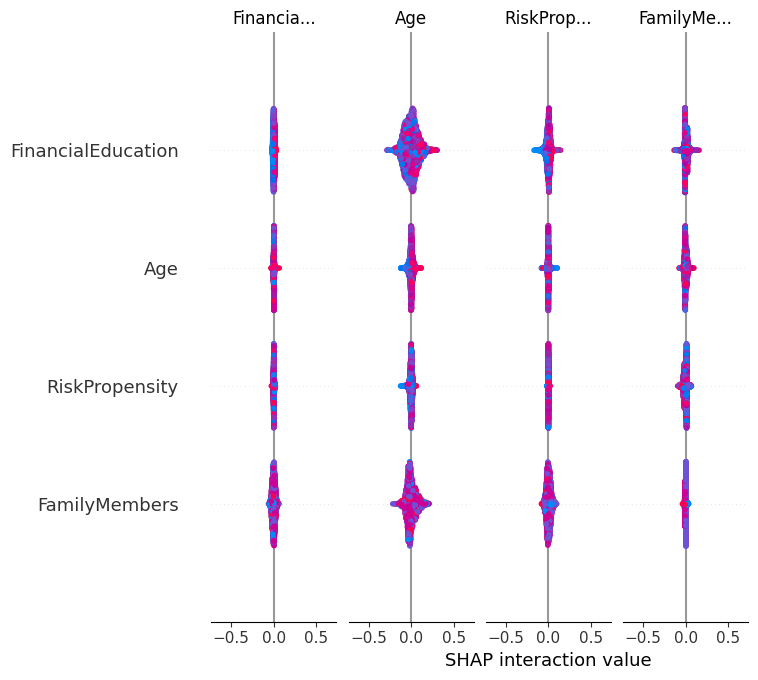

In [37]:
# Create an explainer object
explainer = shap.Explainer(model, np.array(X_train))  # Convert X_train to numpy array

# Compute the Shapley values
shap_values = explainer.shap_values(np.array(X_train))  # Convert X_train to numpy array

# Plot the Shapley values
shap.summary_plot(shap_values, X_train)

### Recommendation

In [38]:
# 3. recommendation
# 3.1. For each cluster compute: median wealth, income, mmax and min risk and inv/acc investment. This should segment nicely
# 3.2. perform tailored recommendation

In [39]:
X_test.index

Int64Index([1501, 2586, 2653, 1055,  705,  106,  589, 2468, 2413, 1600,
            ...
             944, 1268, 4231, 2307, 4424, 4711, 2313, 3214, 2732, 1926],
           dtype='int64', length=1000)

In [40]:
y_pred

array([1, 0, 0, 2, 3, 0, 0, 1, 2, 0, 2, 2, 0, 1, 3, 2, 0, 0, 0, 2, 0, 2,
       1, 0, 2, 1, 0, 0, 1, 0, 2, 2, 2, 3, 2, 2, 3, 0, 0, 3, 2, 2, 2, 0,
       0, 0, 0, 2, 1, 0, 0, 2, 0, 1, 2, 3, 2, 0, 2, 2, 0, 3, 3, 0, 3, 3,
       0, 2, 0, 0, 2, 2, 2, 0, 1, 1, 1, 0, 0, 0, 0, 0, 2, 0, 3, 0, 0, 0,
       2, 0, 0, 1, 1, 0, 0, 3, 2, 0, 2, 0, 0, 1, 0, 2, 0, 0, 0, 0, 2, 2,
       2, 0, 2, 2, 2, 0, 3, 2, 2, 2, 0, 0, 1, 2, 3, 2, 0, 0, 2, 0, 2, 2,
       0, 0, 2, 0, 0, 2, 0, 2, 0, 3, 3, 2, 0, 2, 2, 0, 2, 3, 0, 1, 1, 2,
       3, 1, 0, 3, 0, 0, 2, 0, 1, 1, 0, 2, 0, 2, 2, 3, 0, 1, 0, 0, 1, 0,
       3, 2, 0, 0, 2, 1, 2, 3, 2, 0, 0, 3, 0, 2, 2, 2, 2, 3, 2, 0, 0, 2,
       2, 0, 2, 3, 3, 1, 0, 2, 0, 0, 0, 2, 0, 2, 0, 2, 0, 0, 0, 2, 0, 1,
       1, 2, 2, 3, 1, 3, 3, 0, 1, 0, 1, 0, 1, 1, 0, 2, 2, 1, 0, 1, 0, 1,
       0, 2, 1, 0, 2, 2, 2, 0, 2, 3, 2, 2, 2, 0, 0, 0, 3, 0, 2, 2, 0, 0,
       3, 3, 3, 0, 1, 1, 1, 2, 0, 0, 2, 2, 2, 0, 3, 0, 2, 0, 0, 3, 0, 0,
       0, 0, 0, 0, 0, 3, 1, 1, 3, 1, 2, 1, 0, 0, 2,

In [41]:
# 3. recommendation
def recommend(customers, client_index, y_pred, low_risk=False):
  client = customers.iloc[client_index]
  prop = client['RiskPropensity']
  print(f'Risk propensity of client {client_index} : {prop}')

  if y_pred == 0: #(0,1,2,3)
    return []
  elif y_pred == 1:
    # income investment
    recommendation = products[products['Type'] == 0].sort_values(by='Risk', ascending=low_risk)
  elif y_pred == 2:
    # acc
    recommendation = products[products['Type'] == 1].sort_values(by='Risk', ascending=low_risk)
  elif y_pred == 3:
    recommendation = products.sort_values(by='Risk', ascending=low_risk)

  final = recommendation[recommendation['Risk'] <= client['RiskPropensity']]
  print(final)

  return final

In [42]:
recommend(customers, X_test.index[0], y_pred[0], low_risk=False)

Risk propensity of client 1501 : 0.4165266461050429
   IDProduct  Type  Risk
1          2     0  0.30
9         10     0  0.13
2          3     0  0.12


,IDProduct,Type,Risk
1,2,0,0.30
9,10,0,0.13
2,3,0,0.12


In [43]:
for i in range(0,4):
  recommend(customers, X_test.index[i], y_pred[i], low_risk=False)

Risk propensity of client 1501 : 0.4165266461050429
   IDProduct  Type  Risk
1          2     0  0.30
9         10     0  0.13
2          3     0  0.12
Risk propensity of client 2586 : 0.3050551922354575
Risk propensity of client 2653 : 0.38873844537005386
Risk propensity of client 1055 : 0.785446036976999
   IDProduct  Type  Risk
6          7     1  0.75
0          1     1  0.55
7          8     1  0.48
4          5     1  0.41
5          6     1  0.36
8          9     1  0.27


## Classification - MLP + Recommendation

Now we have to divide data into train-validation-test and train a classifier. I want to do multiclass classification and classify both over IncomeInvestment and AccumulationInvestment.

In [ ]:
import pandas as pd

# Assuming y_inc and y_acc are binary columns containing 0s and 1s
# Create a new numerical variable based on the combinations
df_encoded['CombinedClasses'] = df_encoded['IncomeInvestment'] + 2 * df_encoded['AccumulationInvestment']

# Display the new column
print(df_encoded['CombinedClasses'].value_counts())


2    1568
0    1514
3     998
1     920
Name: CombinedClasses, dtype: int64


In [ ]:
df_encoded.head()

,ID,Age,FamilyMembers,FinancialEducation,RiskPropensity,Income,Wealth,IncomeInvestment,AccumulationInvestment,Gender_0,Gender_1,CombinedClasses
0,1,60,2,0.228685,0.233355,0.183195,0.023386,0,1,1,0,2
1,2,78,2,0.358916,0.170911,0.055719,0.060252,1,0,1,0,1
2,3,33,2,0.317515,0.249703,0.059692,0.029230,0,1,0,1,2
3,4,69,4,0.767685,0.654597,0.452605,0.180963,1,1,0,1,3
4,5,58,3,0.429719,0.349039,0.054012,0.025918,0,0,1,0,0


In [ ]:
df_encoded.drop('ID', axis=1)

,Age,FamilyMembers,FinancialEducation,RiskPropensity,Income,Wealth,IncomeInvestment,AccumulationInvestment,Gender_0,Gender_1,CombinedClasses
0,60,2,0.228685,0.233355,0.183195,0.023386,0,1,1,0,2
1,78,2,0.358916,0.170911,0.055719,0.060252,1,0,1,0,1
2,33,2,0.317515,0.249703,0.059692,0.029230,0,1,0,1,2
3,69,4,0.767685,0.654597,0.452605,0.180963,1,1,0,1,3
4,58,3,0.429719,0.349039,0.054012,0.025918,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...
4995,60,3,0.609411,0.588353,0.023958,0.025227,0,0,0,1,0
4996,65,3,0.523238,0.343272,0.282083,0.069783,1,1,0,1,3
4997,56,3,0.433826,0.402771,0.149977,0.027877,0,1,0,1,2
4998,51,3,0.559793,0.431419,0.167641,0.042246,0,0,0,1,0


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
X_cols = ['Age', 'FamilyMembers', 'FinancialEducation', 'RiskPropensity',
       'Income ', 'Wealth', 'Gender_0', 'Gender_1']
X = df_encoded[X_cols]  # Features
y = df_encoded['CombinedClasses']

# Split the data into training and testing sets for IncomeInvestment
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

y_train_encoded = pd.get_dummies(y_train, prefix='CombinedClasses')
y_test_encoded = pd.get_dummies(y_test, prefix='CombinedClasses')


In [ ]:
tf.random.set_seed(42)

model = Sequential([
    Dense(100, input_dim=X_train.shape[1], activation='relu'),
    Dense(50, activation='relu'),
    Dense(y_train_encoded.shape[1], activation='softmax')
])

model.summary()

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(X_train, y_train_encoded, epochs=200, batch_size=32, validation_split=0.2, callbacks=[early_stopping])


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 100)               900       
                                                                 
 dense_10 (Dense)            (None, 50)                5050      
                                                                 
 dense_11 (Dense)            (None, 4)                 204       
                                                                 
Total params: 6154 (24.04 KB)
Trainable params: 6154 (24.04 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/200
100/100 [==============================] - 1s 6ms/step - loss: 1.5765 - accuracy: 0.2769 - val_loss: 1.3923 - val_accuracy: 0.3237
Epoch 2/200
100/100 [==============================] - 0s 3ms/step - loss: 1.3930 - accuracy: 0.2997 - val_loss: 1.4063 - val_accuracy: 0.266

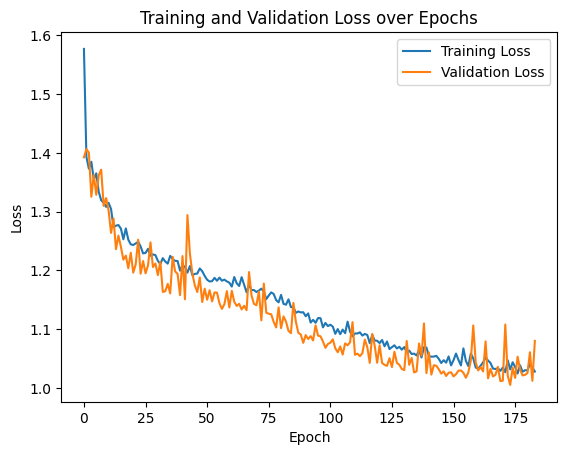

Best Epoch: 174


In [ ]:
# Plot training and validation errors
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.show()

# Identify the best epoch
best_epoch = np.argmin(history.history['val_loss']) + 1
print(f'Best Epoch: {best_epoch}')

In [ ]:
# Predict on the test set
y_pred_proba = model.predict(X_test)
y_pred = np.argmax(y_pred_proba, axis=1)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

32/32 [==============================] - 0s 3ms/step
Accuracy: 0.60


recommender system

In [ ]:
new_client = X_test[0]
print(new_client)
y_pred_new_client = y_pred[0]
print(y_pred_new_client)

print(f' risk propensity {new_client[4]}')

recommendation = products[products['Type'] == 0].sort_values(by='Risk', ascending=False)
print(recommendation)

recommendation[recommendation['Risk'] <= new_client[4]]

[ 64.           0.           2.           0.54287645   0.4419254
  57.65089689 111.58705798   1.           0.75      ]
1
 risk propensity 0.4419254000578127
   IDProduct  Type  Risk
3          4     0  0.44
1          2     0  0.30
9         10     0  0.13
2          3     0  0.12


In [ ]:
def recommend(client, model, low_risk=False):
  y_pred_new_client = model.predict(client, verbose=1)
  print(f' risk propensity {client[4]}')

  if y_pred == 0: #(0,1,2,3)
    return []
  elif y_pred == 1:
    # income investment
    recommendation = products[products['Type'] == 0].sort_values(by='Risk', ascending=low_risk)
  elif y_pred == 2:
    # acc
    recommendation = products[products['Type'] == 1].sort_values(by='Risk', ascending=low_risk)
  elif y_pred == 3:
    recommendation = products.sort_values(by='Risk', ascending=low_risk)

  return recommendation[recommendation['Risk'] <= client[4]]

In [ ]:
def recommend(single_prediction, low_risk=False):
  y_pred_new_client = single_prediction
  print(f' risk propensity {client[4]}')

  if y_pred == 0: #(0,1,2,3)
    return []
  elif y_pred == 1:
    # income investment
    recommendation = products[products['Type'] == 0].sort_values(by='Risk', ascending=low_risk)
  elif y_pred == 2:
    # acc
    recommendation = products[products['Type'] == 1].sort_values(by='Risk', ascending=low_risk)
  elif y_pred == 3:
    recommendation = products.sort_values(by='Risk', ascending=low_risk)

  return recommendation[recommendation['Risk'] <= client[4]]

## MLP - NN

In [ ]:
from sklearn.model_selection import train_test_split
from scipy.stats import truncnorm
from keras.models import Sequential
from keras.layers import Dense

In [ ]:
# customer_features contiene le feature dei clienti
# product_features quelle dei prodotti

customer_features = np.array(customers.drop(['ID', 'IncomeInvestment', 'AccumulationInvestment'], axis=1))
print(customer_features)
product_features = np.array(products.drop('IDProduct', axis=1))
print(product_features)
ratings = np.array(customers[['IncomeInvestment', 'AccumulationInvestment']])
print(ratings)

[[ 60.           0.           2.         ...   0.23335464  68.18152509
   53.26006652]
 [ 78.           0.           2.         ...   0.17091141  21.80759508
  135.55004812]
 [ 33.           1.           2.         ...   0.24970304  23.25274749
   66.30367828]
 ...
 [ 56.           1.           3.         ...   0.40277092  56.09730143
   63.28377375]
 [ 51.           1.           3.         ...   0.43141901  62.52329813
   95.35752787]
 [ 67.           1.           3.         ...   0.35316721  34.3243441
   73.90295983]]
[[1.   0.55]
 [0.   0.3 ]
 [0.   0.12]
 [0.   0.44]
 [1.   0.41]
 [1.   0.36]
 [1.   0.75]
 [1.   0.48]
 [1.   0.27]
 [0.   0.13]
 [1.   0.88]]
[[0 1]
 [1 0]
 [0 1]
 ...
 [0 1]
 [0 0]
 [1 1]]


In [ ]:
# Flatten customer and product features and ratings into X and y matrices
X = np.concatenate((np.tile(customer_features, (num_products, 1)), np.repeat(product_features, num_customers, axis=0)), axis=1)
y = np.tile(ratings, (num_products, 1))

In [ ]:
X.shape

(55000, 9)

In [ ]:
y.shape

(55000, 2)

In [ ]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

Epoch 1/100
1100/1100 [==============================] - 4s 2ms/step - loss: 12.7996 - val_loss: 0.2288
Epoch 2/100
1100/1100 [==============================] - 2s 2ms/step - loss: 0.2517 - val_loss: 0.2232
Epoch 3/100
1100/1100 [==============================] - 2s 2ms/step - loss: 0.2795 - val_loss: 0.1904
Epoch 4/100
1100/1100 [==============================] - 3s 3ms/step - loss: 0.5392 - val_loss: 0.2191
Epoch 5/100
1100/1100 [==============================] - 4s 3ms/step - loss: 0.3245 - val_loss: 0.2047
Epoch 6/100
1100/1100 [==============================] - 3s 3ms/step - loss: 0.2397 - val_loss: 0.2120
Epoch 7/100
1100/1100 [==============================] - 2s 2ms/step - loss: 0.2105 - val_loss: 0.1807
Epoch 8/100
1100/1100 [==============================] - 2s 2ms/step - loss: 0.1888 - val_loss: 0.2182
Epoch 9/100
1100/1100 [==============================] - 4s 3ms/step - loss: 0.2165 - val_loss: 0.1753
Epoch 10/100
1100/1100 [==============================] - 2s 2ms/step - 

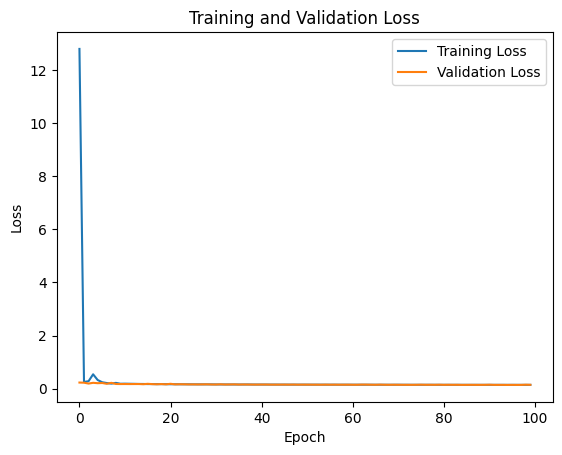

In [ ]:
# Define the neural network architecture
model = Sequential()
model.add(Dense(units=64, activation='relu', input_dim=X.shape[1]))
model.add(Dense(units=32, activation='relu'))
model.add(Dense(units=2, activation='linear'))
# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam')

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train,
                    epochs=100,
                    batch_size=32,
                    verbose=1,
                    validation_data=(X_val, y_val),
                    callbacks=[early_stopping])

# Evaluate the model on the test set
mse_val = model.evaluate(X_val, y_val, verbose=0)
print('Mean Squared Error on Validation Set: ', mse_val)

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [ ]:
# Evaluate the model on the test set
mse_test = model.evaluate(X_test, y_test, verbose=1)
print('Mean Squared Error: ', mse_test)

344/344 [==============================] - 1s 1ms/step - loss: 0.1462
Mean Squared Error:  0.14617714285850525


## Two Towers

In [ ]:
ratings.shape

(5000, 2)

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Concatenate
from tensorflow.keras.models import Model

# Generate synthetic data
N = num_customers  # number of customers
K1 = customer_features.shape[1]  # number of features describing customers
K2 = product_features.shape[1]  # number of features describing products
Q = num_products  # number of products and response variables
Q2 = ratings.shape[1]  # number of products and response variables

np.random.seed(123)  # set the random seed for reproducibility

# Generate synthetic data for customers, products, and ratings
X1 = customer_features  # customer features
X2 = product_features  # product features
ratings = ratings # ratings given by each customer to each product

Epoch 1/50
125/125 [==============================] - 3s 9ms/step - loss: 0.3410 - val_loss: 0.3278
Epoch 2/50
125/125 [==============================] - 1s 8ms/step - loss: 0.3008 - val_loss: 0.2292
Epoch 3/50
125/125 [==============================] - 1s 7ms/step - loss: 0.2263 - val_loss: 0.2179
Epoch 4/50
125/125 [==============================] - 1s 5ms/step - loss: 0.2232 - val_loss: 0.2170
Epoch 5/50
125/125 [==============================] - 1s 9ms/step - loss: 0.2221 - val_loss: 0.2108
Epoch 6/50
125/125 [==============================] - 2s 12ms/step - loss: 0.2085 - val_loss: 0.1806
Epoch 7/50
125/125 [==============================] - 1s 12ms/step - loss: 0.1903 - val_loss: 0.1764
Epoch 8/50
125/125 [==============================] - 2s 12ms/step - loss: 0.1851 - val_loss: 0.1755
Epoch 9/50
125/125 [==============================] - 1s 11ms/step - loss: 0.1870 - val_loss: 0.1842
Epoch 10/50
125/125 [==============================] - 1s 9ms/step - loss: 0.1820 - val_loss: 0.

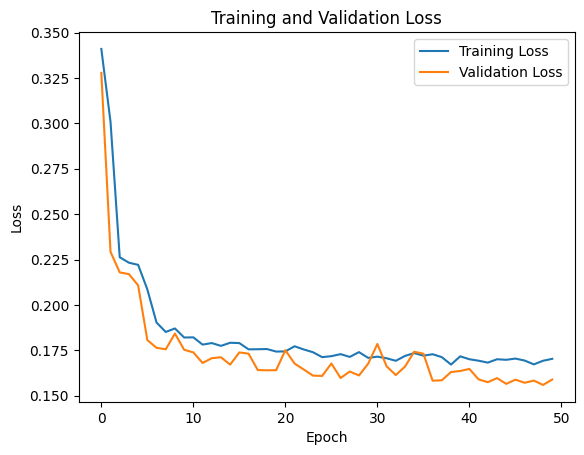

In [ ]:
# Build Two Tower model
input1 = Input(shape=(K1,))  # input layer for customer features
input2 = Input(shape=(K2,))  # input layer for product features
x1 = Dense(32, activation='relu')(input1)  # first hidden layer for customer features
x2 = Dense(32, activation='relu')(input2)  # first hidden layer for product features
x = Concatenate()([x1, x2])  # concatenate the output from the two hidden layers
output = Dense(Q2, activation='sigmoid')(x)  # output layer for predicted ratings
model = Model(inputs=[input1, input2], outputs=output)  # define the model

# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam')

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)

# Train the model on the synthetic dataset
history = model.fit([X1, np.tile(X2, (N, 1))], ratings, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [ ]:
# Generate new synthetic data for prediction
N_new = 10  # number of new customers
X1_new = X_test  # new customer features
X2_new = np.random.rand(Q, K2)  # product features for the existing products

# Do prediction on new data
predicted_ratings = model.predict([X1_new, np.tile(X2_new, (N_new, 1))[:N_new]])  # predict ratings for the new customers
print(predicted_ratings)  # print the predicted ratings = top goals/needs

LightGBM Classifier

In [ ]:
X_cols = ['Age', 'FamilyMembers', 'FinancialEducation', 'RiskPropensity',
       'Income ', 'Wealth', 'Gender_0', 'Gender_1']
X = df_encoded[X_cols]  # Features
y = df_encoded['CombinedClasses']

# Split the data into training and testing sets for IncomeInvestment
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

y_train_encoded = pd.get_dummies(y_train, prefix='CombinedClasses')
y_test_encoded = pd.get_dummies(y_test, prefix='CombinedClasses')

In [ ]:
import lightgbm as lgb
from sklearn.metrics import accuracy_score, precision_score, recall_score


params = {
    'objective': 'multiclass',
    'num_class': len(y.unique()),  # Number of classes
    'metric': 'multi_logloss',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0
}


train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test)

model = lgb.train(params, train_data, num_boost_round=100, valid_sets=[test_data])

y_pred = model.predict(X_test, num_iteration=model.best_iteration)
y_pred_class = [np.argmax(x) for x in y_pred]

accuracy = accuracy_score(y_test, y_pred_class)
precision = precision_score(y_test, y_pred_class, average='weighted')
recall = recall_score(y_test, y_pred_class, average='weighted')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
Accuracy: 0.66
Precision: 0.6608893019929797
Recall: 0.66


XGBoost

In [ ]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, precision_score, recall_score

params = {
    'objective': 'multi:softmax',
    'num_class': len(y.unique()),
    'eval_metric': 'merror',
    'eta': 0.1,
    'max_depth': 6,
    'min_child_weight': 1,
    'gamma': 0,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'seed': 42
}

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

num_round = 100
model = xgb.train(params, dtrain, num_round)

y_pred = model.predict(dtest)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.652
Precision: 0.6513966942362708
Recall: 0.652


In [ ]:
# LightGBM Tuned


from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score

# Define the LightGBM classifier
lgb_classifier = lgb.LGBMClassifier(objective='multiclass', num_class=len(y.unique()))

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'learning_rate': [0.05, 0.1, 0.2],
    'num_leaves': [20, 30, 40],
    'max_depth': [5, 7, 10],
    'min_child_samples': [10, 20, 30],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

# Define the scoring metric
scorer = make_scorer(accuracy_score)

# Perform GridSearchCV
grid_search = GridSearchCV(estimator=lgb_classifier, param_grid=param_grid, scoring=scorer, cv=5, verbose=0)
grid_search.fit(X_train, y_train)

# Print the best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

Streaming output truncated to the last 5000 lines.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000277 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1100
[LightGBM] [Info] Number of data points in the train set: 3200, number of used features: 8
[LightGBM] [Info] Start training from score -1.193610
[LightGBM] [Info] Start training from score -1.697586
[LightGBM] [Info] Start training from score -1.162151
[LightGBM] [Info] Start training from score -1.604761
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga